# Práctico Machine Learning UNSAM

La <b>Emisión Acústica</b> (EA) es un método de ensayos no destructivos que detecta, mediante un sensor piezoeléctrico, el desplazamiento producido por ondas superficiales (en el rango de 20 kHz a 1 MHz) propagadas por un medio sólido. Se adquieren señales temporales (formas de onda, cuando la señal cruza un determinado umbral en amplitud) pero como su tasa de bits es muy alta (frecuencia de muestreo mayor a 2 MHz y resolución de 18 bits) se utilizan distintos parámetros, usualmente asociados a descriptores eléctricos o espectrales, obteniéndose lo que se conocen como parámetros de EA.


<img src="parámetros.png" alt="jij" style="width: 400px;"/>


El <b>LIBS</b> (acrónimo de Laser-induced breakdown spectroscopy) es un tipo de espectroscopía de emisión atómica que utiliza un pulso láser altamente energético como fuente de excitación. El láser se enfoca para formar un plasma, que atomiza y excita muestras, devolviéndonos un espectro. Una vez obtenido ese espectro, se podrá seleccionar un pico y se verá la Intensidad  Relativa del elemento que seleccionamos. -


<img src="pulso.png" alt="LIBS" style="width: 400px;"/>


En este trabajo se busca reemplazar la técnica LIBS por el método de EA para la detección de distintas capas de un material compuesto laminado, constituido por aluminio, una interfaz adherente y polímero reforzado de fibra de carbono (CFRP por sus siglas en inglés). Esto se hará utilizando los parámetros de EA (que definieremos posteriormente).

Primero definimos algunas funciones que vamos a utilizar a lo largo del notebook

In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
import seaborn
seaborn.set(style="ticks", color_codes=True)


def File2Array(filename):
	with open(filename) as f:
		listFile = f.readlines()	#separa linea por linea el archivo de texto
	listFile = [listFile[n:] for n, i in enumerate(listFile) if 'ID' in listFile[n]][0] #recorta el header
	listFile = list(map(lambda s: s.strip(), listFile))								#elimina los \n de los strings grandes
	listFile = [list(filter(None, listFile[i].split(' '))) for i in range(len(listFile))]	#divide según los espacios en listas
	listFile = ColumnNameCorrector(listFile)
	header = listFile[0]
	listFile = listFile[1:]
	array = [[castIntoIntOrFloatSmartly(i) for i in listFile[j]] for j in range(len(listFile))]

	return array, header

def GetDescriptionFromFile(filename):
	with open(filename) as f:
		listFile = f.readlines()
	description = [listFile[:n] for n, i in enumerate(listFile) if 'ID' in listFile[n]][0]
	return description

def ColumnNameCorrector(listFile):
	if len(listFile[0]) > len(listFile[1]) and 'SIG' in listFile[0]:
		index = listFile[0].index('SIG')
		listFile[0][index: index + 2] = ['-'.join(listFile[0][index:index + 2])]
	return listFile

def castIntoIntOrFloatSmartly(s):
	f = float(s)
	i = int(f)
	return i if i == f else f

def File2PandasTable(filename):
	array, nameOfColumns = File2Array(filename)
	if len(nameOfColumns) != len(array[0]):
		nameOfColumns = nameOfColumns[0].split('\t')
	table = pandas.DataFrame(array, columns=nameOfColumns)
	table = table.rename(columns={'SSSSSSSS.mmmuuun': 'Tiempo',  'ABS-ENERGY':'ABS_ENERGY', 'C-FRQ':'C_FRQ',
								  'P-FRQ':'P_FRQ', 'A-FRQ':'A_FRQ', 'R-FRQ':'R_FRQ', 'I-FRQ':'I_FRQ', 'SIG-STRNGTH': 'SIG_STRNGTH'})
	return table

#Esta función es para buscar las formas de onda a partir de los hits
def FromParameterToWaveformWithoutHit(filename, channel, time):
	# timeFloor = int(time)-1
	# timeCeil = int(time) + 1
	# timeList = [timeFloor, time, timeCeil]
	time = re.sub('[.]', '', str(round(time, 6)))
	numbers = range(-5, 6, 1)
	N = range(len(numbers))
	timeList = [int(time) + numbers[i] for i in N]
	return ['{}_{}_{}.txt'.format(filename, channel, timeList[i]) for i in N]

Ahora visualizamos las señales de intensidad relativa del aluminio (Al) y del carbono (C). Tenemos tres materiales a identificar.
Aluminio: son los puntos intermedios de la señal de LIBS Al
Interfaz: son los picos más altos. Esto se debe a una interacción entre las partículas de aluminio que tiene el adhesivo y el láser.
CFRP: son los puntos altos de carbono

Index(['Hit', 'Energia', 'IRAl', 'IRC', 'RMS', 'Amplitud', 'A-Frec', 'I-Frec',
       'R-Frec', 'P-Frec', 'Intensidad', 'Rise Time', 'Cuentas'],
      dtype='object')

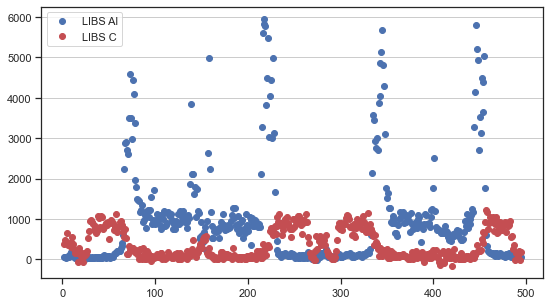

In [4]:
data = pandas.read_excel('MedicionesEALibs.xlsx')
data = data.rename(columns={"Energia de EA": "Energia", "Int. Rel. de Al": "IRAl",	"Int. Rel. de C":"IRC", "Int. de Senal":"Intensidad"})
plt.figure(figsize=(9,5))
plt.plot(data['Hit'], data['IRAl'], 'bo', label='LIBS Al')
plt.plot(data['Hit'], data['IRC'], 'ro', label='LIBS C')
plt.legend()
plt.grid(axis='y')

data.columns

A continuación, definimos cada una de las variables que contienen los datos:

Hit: Denominación que se le da a cada una de las formas de onda detectadas.

Energía: Es el área bajo la curva de la forma de onda

RMS: Valor cuadrático medio de la señal

Cuentas: Cantidad de veces que la forma de onda cruza el umbral

Amplitud: Amplitud pico de la forma de onda

Rise Time: Tiempo de subida desde que la señal es detectada hasta que llega al pico

A-Frec: Frecuencia promedio de la forma de onnda

R-Frec: Frecuencia de reverberancia

P-Frec: Frecuencia pico

IRAl: Intensidad relativa del aluminio

IRC: Intensidad relativa del Carbono


Según el criterio establecido anteriormente, separamos cada una de las señales de LIBS según el material:

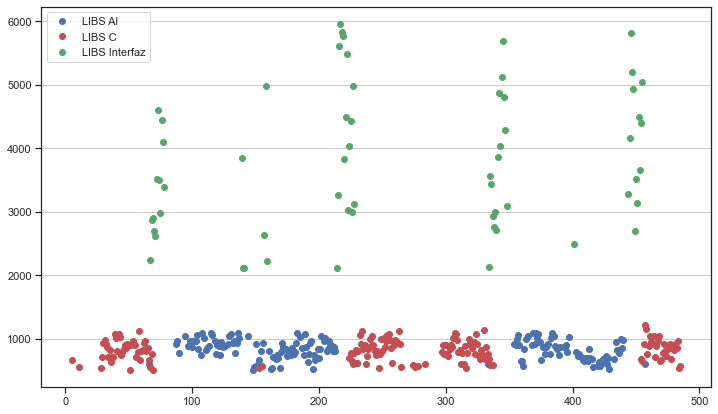

In [6]:
cfilt = data[data.IRC>500]
alfilt = data[(data.IRAl>500) & (data.IRAl<1100)]
intfilt = data[(data.IRAl>2000)]

plt.figure(figsize=(12,7))
plt.plot(alfilt['Hit'], alfilt['IRAl'], 'bo',label='LIBS Al')
plt.plot(cfilt['Hit'], cfilt['IRC'], 'ro', label='LIBS C')
plt.plot(intfilt['Hit'], intfilt['IRAl'], 'go' , label='LIBS Interfaz')
plt.legend()
plt.grid(axis='y')

# deletedCols = ['IRAl', 'IRC', 'Hit', 'R-Frec', 'P-Frec', 'I-Frec', 'A-Frec', 'Cuentas', 'Amplitud', 'Intensidad', 'Rise Time']
deletedCols = ['IRAl', 'IRC', 'Hit']
alfilt = alfilt.drop(columns=deletedCols)
t_al = np.zeros(len(alfilt))
cfilt = cfilt.drop(columns=deletedCols)
t_c = np.ones(len(cfilt))
intfilt = intfilt.drop(columns=deletedCols)
t_int = 2*np.ones(len(intfilt))


In [7]:
X = pandas.concat([alfilt, cfilt, intfilt])
y = np.concatenate([t_al, t_c, t_int])

columns = X.columns
columns

Index(['Energia', 'RMS', 'Amplitud', 'A-Frec', 'I-Frec', 'R-Frec', 'P-Frec',
       'Intensidad', 'Rise Time', 'Cuentas'],
      dtype='object')

Ahora ploteamos todas las distribuciones para ver si hay  alguna separación notoria

Se puede comentar y descomentar las 3 líneas que permiten ver las distribuciones "logaritmizadas" o sin aplicarles ningún procesamiento.



c:\users\augusto\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


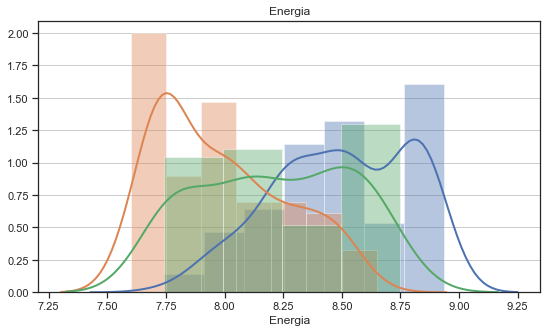

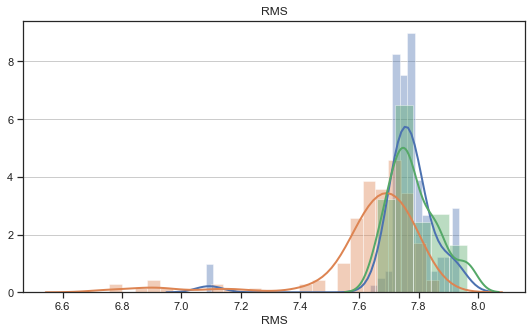

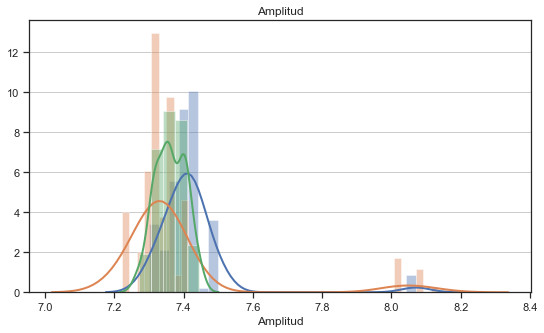

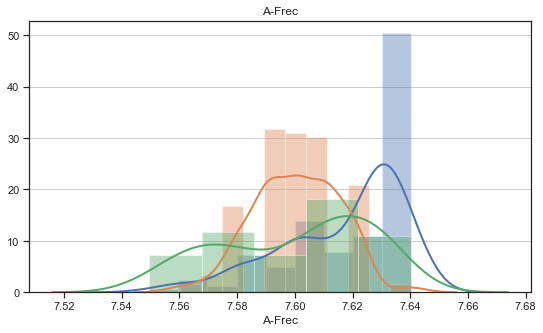

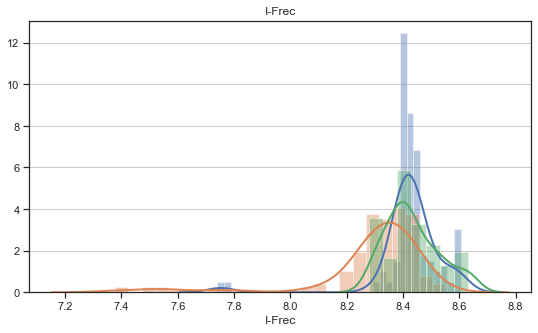

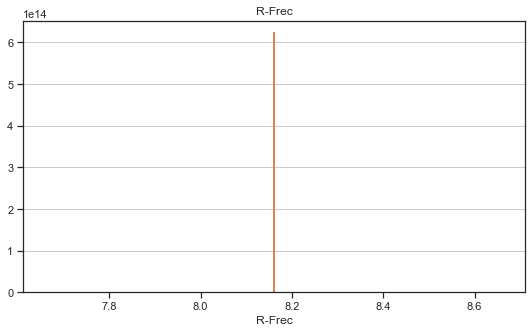

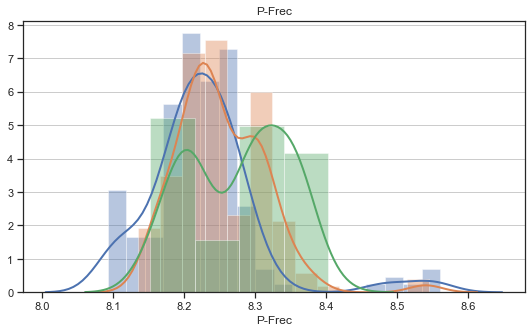

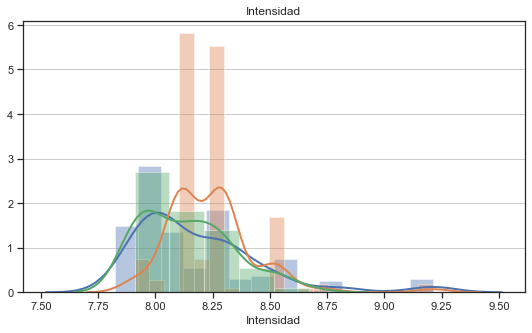

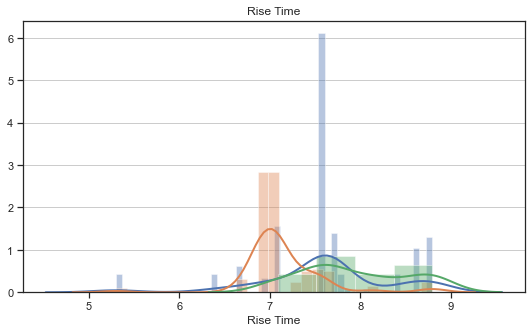

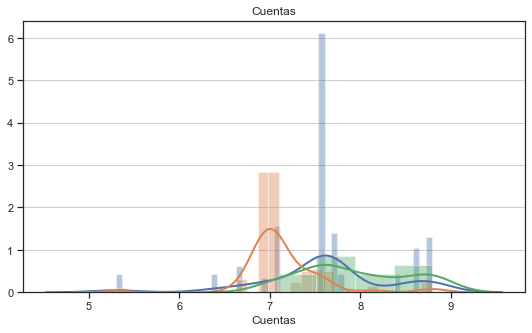

In [8]:
for col in columns:
    plt.figure(figsize=(9,5))
    plt.title(col)
    plt.grid(axis='y')
    
#     seaborn.distplot(alfilt[col], kde_kws=dict(linewidth=2))
#     seaborn.distplot(cfilt[col], kde_kws=dict(linewidth=2))
#     seaborn.distplot(intfilt[col], kde_kws=dict(linewidth=2))
    
    seaborn.distplot(np.log(alfilt[col]), kde_kws=dict(linewidth=2))
    seaborn.distplot(np.log(cfilt[col]), kde_kws=dict(linewidth=2))
    seaborn.distplot(np.log(intfilt[col]), kde_kws=dict(linewidth=2))

Sumamos un gráfico para ver todas las variables contra todas las variables juntas y después aplicamos un algoritmo que nos permite obtener el índice de correlación de cada variable con nuestro target.

Cabe destacar que cuando se obtienen los cuatro primeros valores del índice de correlación, se utiliza el valor absoluto, por lo que los índices son todos positivos. En el gráfico se puede distinguir si están positiva o negativamente correlacionados

c:\users\augusto\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
c:\users\augusto\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
c:\users\augusto\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

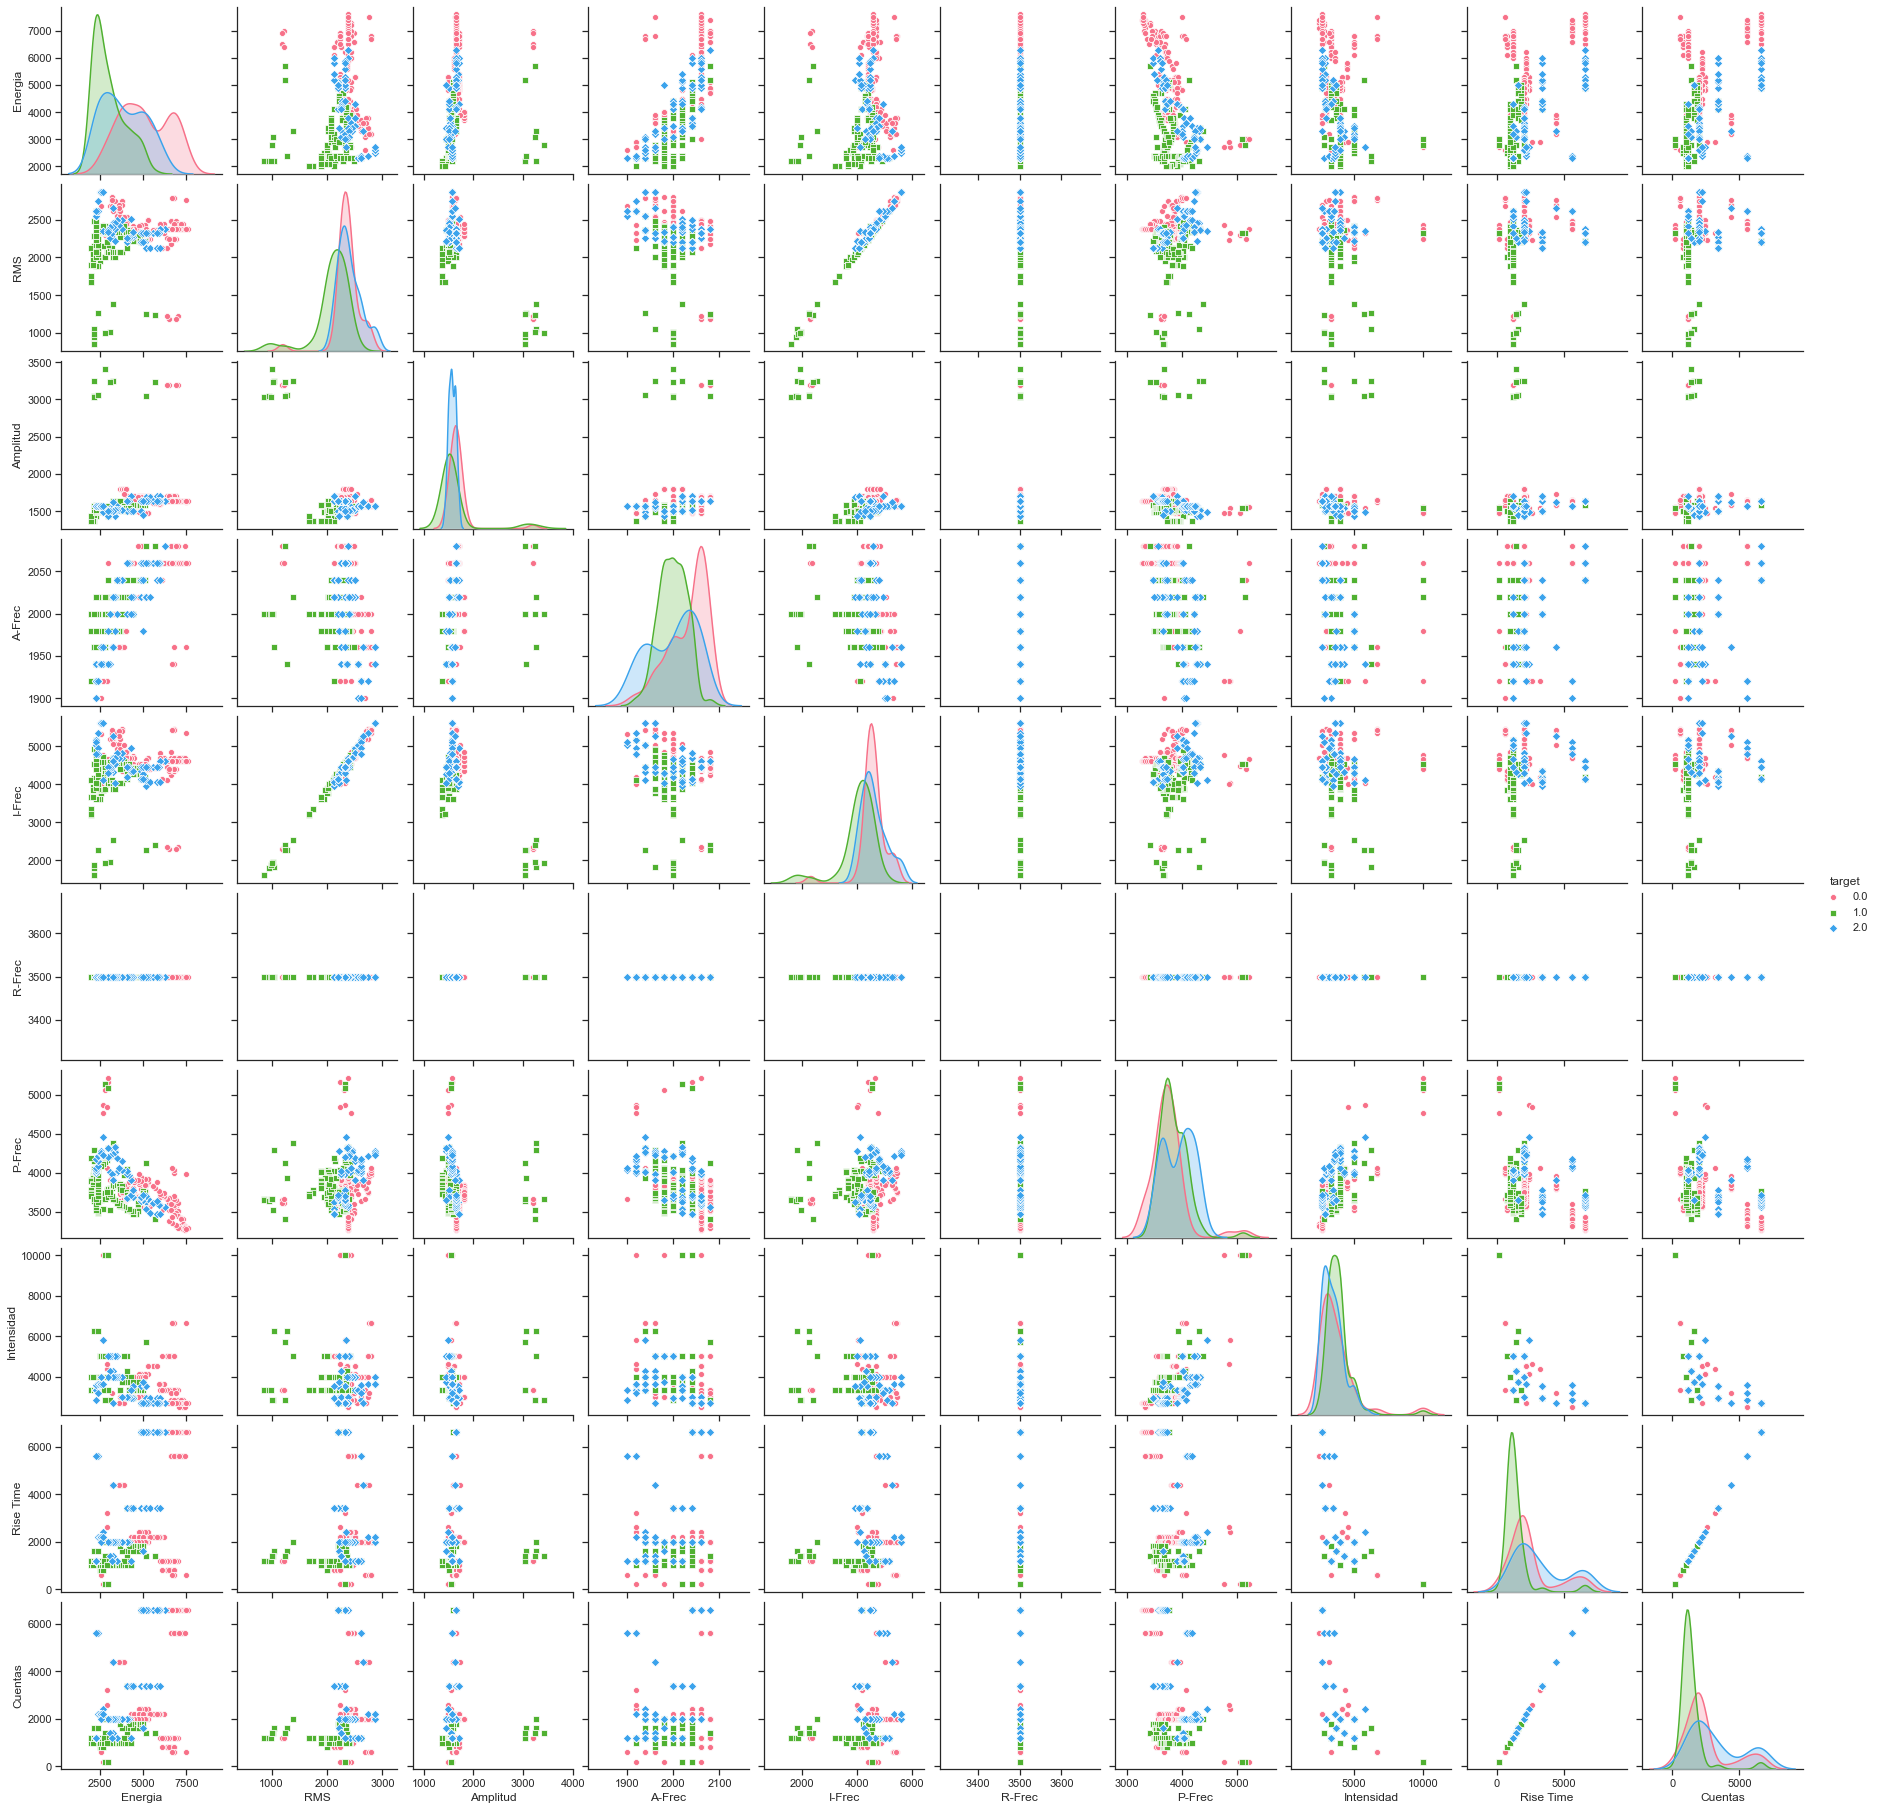

Los índices de correlación de cada variable con el target: 
 target        1.000000
Energia       0.436705
A-Frec        0.339325
P-Frec        0.218953
I-Frec        0.118843
Amplitud      0.117804
RMS           0.094235
Intensidad    0.053002
Cuentas       0.026038
Rise Time     0.026038
R-Frec             NaN
Name: target, dtype: float64
['target', 'Energia', 'A-Frec', 'P-Frec', 'I-Frec']


<Figure size 432x288 with 0 Axes>

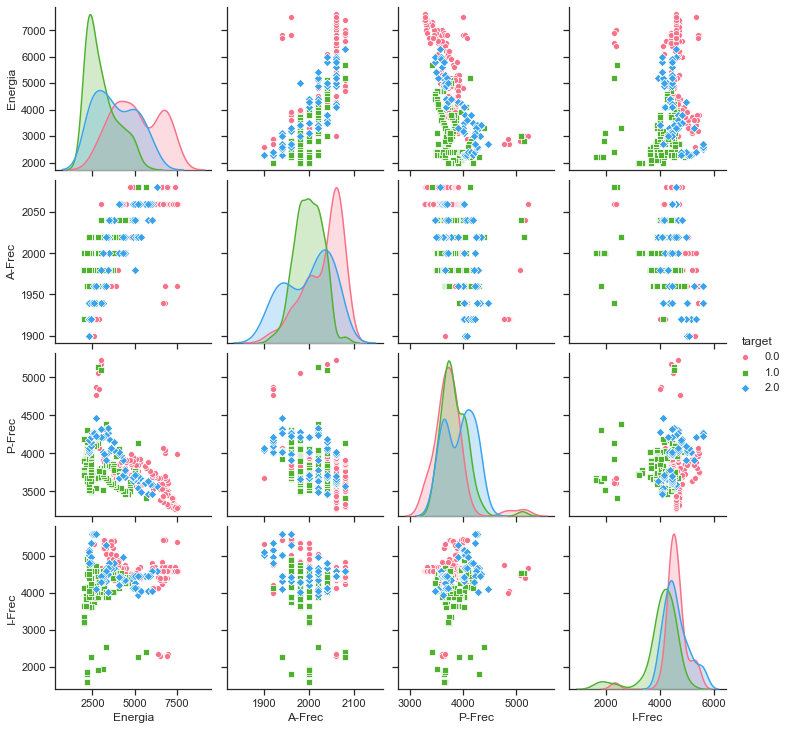

In [12]:
X['target'] = y
plt.figure()
seaborn.pairplot(X, hue="target", markers=["o", "s", "D"], palette="husl")
plt.show()


# data['target'] = y

correlation = X.corr()
targetCorrelation = correlation["target"].abs().sort_values(ascending=False)

print('Los índices de correlación de cada variable con el target: \n', targetCorrelation)

attributes = list(targetCorrelation.index[:5])
print(attributes)
plt.figure()
seaborn.pairplot(X[attributes], hue="target", markers=["o", "s", "D"], palette="husl") #, hue="target", markers=["o", "s", "D"], palette="husl")

X = X.drop(columns=['target'])

### Clasificación Balanceada

Dado que la interfaz tiene una cantidad sustantivamente menor de muestras, haremos la clasificación teniendo esto en cuenta.

Al igual que antes, dejé una línea comentada que permite "logaritmizar" el conjunto de datos si se la descomenta (X_aux). El entrenamiento funciona mejor sin aplicar el logaritmo, por lo que se lo dejó como default. La predicción es muy similar.

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# X_aux = X.drop(columns=)
# X_aux = np.log(X.values)
X_aux = X.values

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=8)
for train_index, test_index in split.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train_bal, X_test_bal = X_aux[train_index], X_aux[test_index]
    y_train_bal, y_test_bal = y[train_index], y[test_index]
    
clf_bal = RandomForestClassifier(random_state=5, class_weight='balanced')

parametersRF = {
    'bootstrap': [True],
    'max_depth' : [5,10,15,20, 25, 30, 40, 50, 60, 70, 80],
    'min_samples_leaf': [3, 4, 6, 8],
    'min_samples_split': [8, 10, 12, 15, 18],
    'n_estimators': [200, 500, 700,1000, 2000]
}
RF_best = RandomizedSearchCV(clf_bal,parametersRF, 
                          cv = 10, n_jobs = -1, verbose = 2)

RF_best.fit(X_train_bal, y_train_bal)

y_train_pred_bal = RF_best.predict(X_train_bal)
accuracy_train_bal = balanced_accuracy_score(y_train_bal, y_train_pred_bal)
print('Train accuracy balanced: ', accuracy_train_bal)

y_test_pred_bal = RF_best.predict(X_test_bal)
accuracy_test_bal = balanced_accuracy_score(y_test_bal, y_test_pred_bal)
print('Test accuracy balanced: ', accuracy_test_bal)
print('\n')

print('Matriz de confusión de train:\n', confusion_matrix(y_train_bal, y_train_pred_bal))#[[tn, fp],[fp, tp]])
print('Matriz de confusión de test:\n', confusion_matrix(y_test_bal, y_test_pred_bal))#[[tn, fp],[fp, tp]])


    

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   36.8s finished


Train accuracy balanced:  0.9524848107181804
Test accuracy balanced:  0.8762626262626263


Matriz de confusión de train:
 [[128   3   0]
 [  2 118  11]
 [  1   0  48]]
Matriz de confusión de test:
 [[32  1  0]
 [ 0 30  3]
 [ 2  1  9]]


#### Feature importance

Ahora vemos los feature importance del Random Forest:

In [10]:
print('Feature importance:')
for name, score in zip(X.columns, RF_best.best_estimator_.feature_importances_):
    print('{}: {}'.format(name, round(score,2)))

Feature importance:
Energia: 0.14
RMS: 0.12
Amplitud: 0.09
A-Frec: 0.07
I-Frec: 0.1
R-Frec: 0.0
P-Frec: 0.14
Intensidad: 0.04
Rise Time: 0.16
Cuentas: 0.15


En el feature importance del Random Forest también podemos observar que la energía es un componente clave para la clasificación de los datos. 
Hay diferencias con respecto al índice de correlación, pero también podemos ver que los parámetros espectrales (asociados a la frecuencia) tienen una importancia destacable para la clasificar los datos.

(

Dejo acá los primeros valores de Correlación así no los buscan:

Energia       0.436705

A-Frec        0.339325

P-Frec        0.218953

I-Frec        0.118843

Amplitud      0.117804

RMS           0.094235

)

#### Comparación entre Feature importance y correlación

<Figure size 432x288 with 0 Axes>

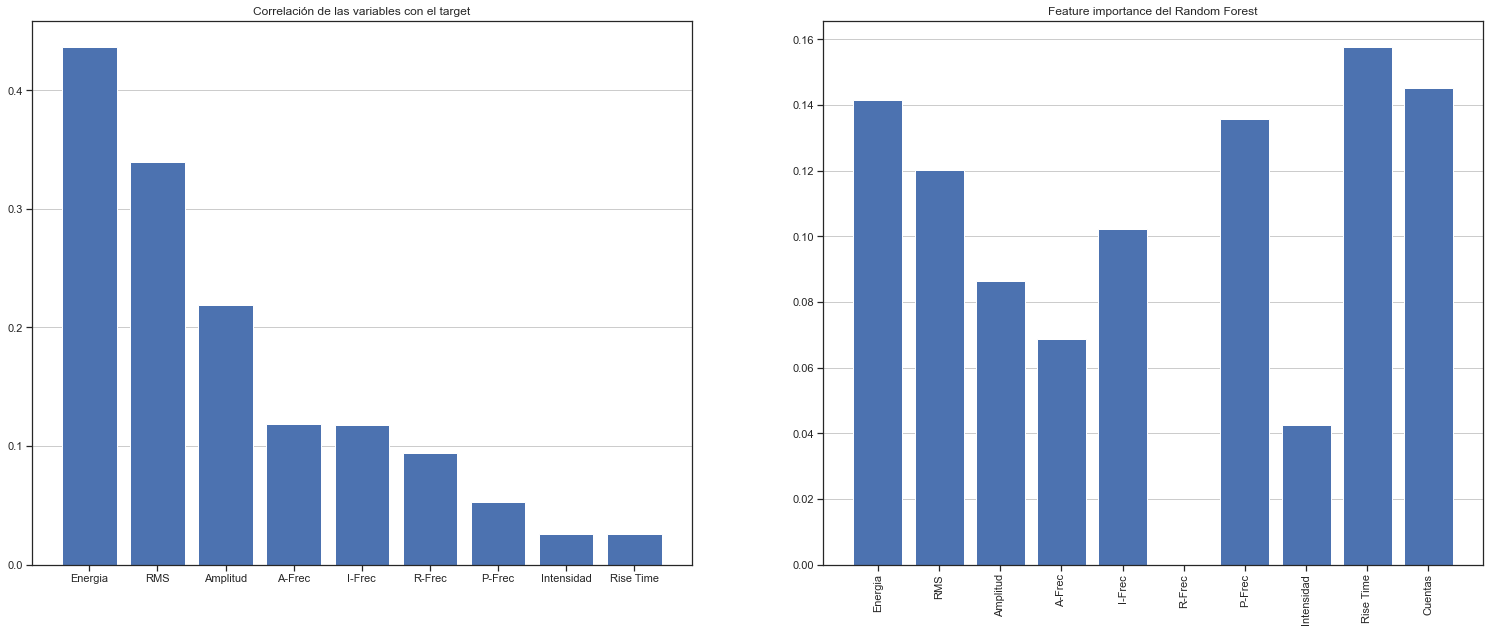

In [13]:
plt.figure()
fig, ax = plt.subplots(1,2, figsize=(26,10))
ax[0].set_title('Correlación de las variables con el target')
ax[0].bar(X.columns, targetCorrelation[1:])
ax[0].grid(axis='y')

ax[1].set_title('Feature importance del Random Forest')
ax[1].bar(X.columns, RF_best.best_estimator_.feature_importances_)
plt.xticks(range(10), rotation='vertical')
ax[1].grid(axis='y')
plt.show()


#### Aplicación de funciones base
Por último vamos a evaluar los datos aplicando funciones base no lineales para ver si mejora la clasificación.

(No me deja usar un polinomio mayor a diez porque dice que hay valores que son Nan. Supongo que algo da cero y eso complica las cosas)

De todas formas, podemos ver que a medida que el polinomio crece, la clasificación empeora.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures

# X_aux = X.drop(columns=)
# X_aux = np.log(X.values)
for n in np.arange(2,16,2):
    print('Polinomio de grado ', n)
    poly = PolynomialFeatures(n)
    X_aux = poly.fit_transform(X.values)


    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=8)
    for train_index, test_index in split.split(X, y):
    #     print("TRAIN:", train_index, "TEST:", test_index)
        X_train_bal, X_test_bal = X_aux[train_index], X_aux[test_index]
        y_train_bal, y_test_bal = y[train_index], y[test_index]

    clf_bal = RandomForestClassifier(random_state=5, class_weight='balanced')

    parametersRF = {
        'bootstrap': [True],
        'max_depth' : [5,10,15,20, 25, 30, 40, 50, 60, 70, 80],
        'min_samples_leaf': [3, 4, 6, 8],
        'min_samples_split': [8, 10, 12, 15, 18],
        'n_estimators': [200, 500, 700,1000, 2000]
    }
    RF_best = RandomizedSearchCV(clf_bal,parametersRF, 
                              cv = 10, n_jobs = -1, verbose = 2)

    RF_best.fit(X_train_bal, y_train_bal)

    y_train_pred_bal = RF_best.predict(X_train_bal)
    accuracy_train_bal = balanced_accuracy_score(y_train_bal, y_train_pred_bal)
    print('Train accuracy balanced: ', accuracy_train_bal)

    y_test_pred_bal = RF_best.predict(X_test_bal)
    accuracy_test_bal = balanced_accuracy_score(y_test_bal, y_test_pred_bal)
    print('Test accuracy balanced: ', accuracy_test_bal)
    print('\n')

    print('Matriz de confusión de train:\n', confusion_matrix(y_train_bal, y_train_pred_bal))#[[tn, fp],[fp, tp]])
    print('Matriz de confusión de test:\n', confusion_matrix(y_test_bal, y_test_pred_bal))#[[tn, fp],[fp, tp]])
    print('')
    print('')

Polinomio de grado  2
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   41.1s finished


Train accuracy balanced:  0.9567430025445293
Test accuracy balanced:  0.893939393939394


Matriz de confusión de train:
 [[127   3   1]
 [  2 118  11]
 [  0   0  49]]
Matriz de confusión de test:
 [[32  1  0]
 [ 1 29  3]
 [ 1  1 10]]


Polinomio de grado  4
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished


Train accuracy balanced:  0.9473957521940074
Test accuracy balanced:  0.893939393939394


Matriz de confusión de train:
 [[125   3   3]
 [  2 119  10]
 [  1   0  48]]
Matriz de confusión de test:
 [[31  2  0]
 [ 0 30  3]
 [ 0  2 10]]


Polinomio de grado  6
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   54.1s
